# 0) Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
from cartopy import crs as ccrs, feature as cfeature

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120

print('xarray', xr.__version__)


xarray 2025.9.0


In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on my machine
print(client.dashboard_link)

http://127.0.0.1:8787/status


2025-09-27 22:38:26,837 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:44839 (pid=3572) exceeded 95% memory budget. Restarting...
2025-09-27 22:38:26,888 - distributed.nanny - WARNING - Restarting worker
2025-09-27 22:38:31,538 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:36477 (pid=3577) exceeded 95% memory budget. Restarting...
2025-09-27 22:38:31,567 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:36477' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'shuffle-taker-0f662fadc664725d71177cdf0bd15c07', 'shuffle-taker-3a2070fa4b790b9270b76db9ae9a867d', 'shuffle-taker-33c2d61229d2514f6acc14e7ea39d9fe', 'shuffle-taker-acb80688bcdcb972cf49c53589c3ec7d', 'shuffle-taker-1d590ac5e19589240622b5289c4ac11a', 'shuffle-taker-279b527c3fb7615ab6670e180bc2c3d7', 'shuffle-sorter-0d35707489e1f271b89f9308a03a8747', 'shuffle-taker-c282c0ed17175ab89375e9a315ef546c', 'shuffle-taker-883315039fa44a5fea0480d258ca13

In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem(token="anon")
# Should list arrays/metadata keys under the store
print(fs.ls("gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3")[:10])

['gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_wind_gust_since_previous_post_processing']


# 1) Subsetting Precipitation data of Charleston, SC for 20 years

In [4]:
#Opening data
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={'time':1000},
    storage_options=dict(token='anon'),
)
ds = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))

#Define var as precipitation to subset data later.
var = 'total_precipitation'
ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 3TB dask.array<chunksize=(384, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-09-27 01:56:06.571799+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-21

In [5]:
#Subsetting data to include precipitation during the first 20 years of my life :)
dss = ds[var]

dss = dss.sel(time=slice('2000-08-25 00:00', '2020-08-24 23:59'))

dss

<xarray.DataArray 'total_precipitation' (time: 175320, latitude: 721,
                                         longitude: 1440)> Size: 728GB
dask.array<getitem, shape=(175320, 721, 1440), dtype=float32, chunksize=(1000, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1MB 2000-08-25 ... 2020-08-24T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [6]:
#Subset the data further to include a 5x5 grid of Charleston, SC
lons = [280, 285]
lats = [30, 35]

dsss = dss.sel(latitude=slice(lats[1],lats[0]), longitude=slice(lons[0],lons[1]))

dsss

<xarray.DataArray 'total_precipitation' (time: 175320, latitude: 21,
                                         longitude: 21)> Size: 309MB
dask.array<getitem, shape=(175320, 21, 21), dtype=float32, chunksize=(1000, 21, 21), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 84B 35.0 34.75 34.5 34.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float32 84B 280.0 280.2 280.5 ... 284.5 284.8 285.0
  * time       (time) datetime64[ns] 1MB 2000-08-25 ... 2020-08-24T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

# 2) 95% Values of Daily Precipitation

In [7]:
dsss_daily = xr.open_dataset('era5_CHS_precip_08252000_08242020.nc')

CHS_95 = dsss_daily.quantile(0.95, dim='time')

CHS_95

<xarray.Dataset> Size: 4kB
Dimensions:              (latitude: 21, longitude: 21)
Coordinates:
  * latitude             (latitude) float32 84B 35.0 34.75 34.5 ... 30.25 30.0
  * longitude            (longitude) float32 84B 280.0 280.2 ... 284.8 285.0
    quantile             float64 8B 0.95
Data variables:
    total_precipitation  (latitude, longitude) float64 4kB 16.45 16.52 ... 16.41

Text(0.5, 1.0, 'CDF of 95% Values of Daily Precipitation in CHS')

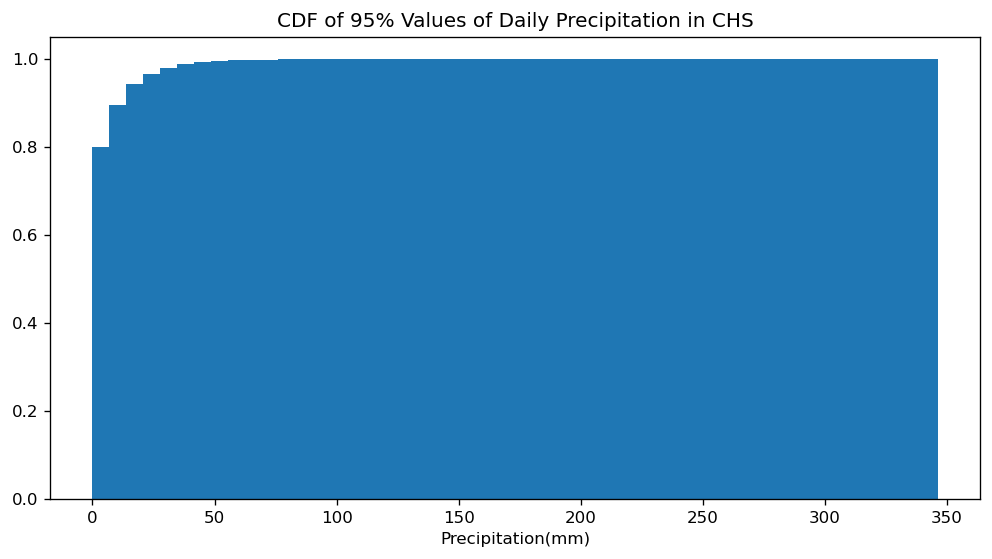

In [8]:
# turn to np?
CHS_flat = dsss_daily['total_precipitation'].values.flatten()
CHS_sorted = np.sort(CHS_flat)

plt.hist(CHS_sorted, bins=50, density=True, cumulative=True)
plt.xlabel('Precipitation(mm)')
plt.title('CDF of 95% Values of Daily Precipitation in CHS')

# 3) Compostie mean & anomaly maps

In [9]:
dss

<xarray.DataArray 'total_precipitation' (time: 175320, latitude: 721,
                                         longitude: 1440)> Size: 728GB
dask.array<getitem, shape=(175320, 721, 1440), dtype=float32, chunksize=(1000, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1MB 2000-08-25 ... 2020-08-24T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [10]:
# US Composite mean calculation 

# Select US only lat and lons
lons_US = [-67+360, -124+360]
lats_US = [25, 50]

precip_US = ds['total_precipitation'].sel(latitude=slice(lats_US[1], lats_US[0]), longitude=slice(lons_US[1], lons_US[0]))

precip_US

<xarray.DataArray 'total_precipitation' (time: 748008, latitude: 101,
                                         longitude: 229)> Size: 69GB
dask.array<getitem, shape=(748008, 101, 229), dtype=float32, chunksize=(1000, 101, 229), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 404B 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 916B 236.0 236.2 236.5 ... 292.5 292.8 293.0
  * time       (time) datetime64[ns] 6MB 1940-01-01 ... 2025-04-30T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [11]:
CHS_series = dsss_daily['total_precipitation'].sel(
    latitude=32.8, longitude=280.0, method="nearest"
)

CHS_95 = CHS_series.quantile(0.95)
CHS_days = CHS_series.time.where(CHS_series > CHS_95, drop=True)

CHS_days = CHS_days.values


In [12]:
precip_US95 = precip_US.sel(time=CHS_days)


US_mean = precip_US95.mean(dim='time')

In [13]:
# preparing subset of data 1981-2010

precip_81_10 = ds['total_precipitation']

precip_81_10 = precip_81_10.sel(time=slice('1981-01-01 00:00', '2010-12-31 23:59'))

precip_81_10 = precip_81_10.sel(latitude=slice(lats_US[1], lats_US[0]), longitude=slice(lons_US[1], lons_US[0]))

precip_81_10

<xarray.DataArray 'total_precipitation' (time: 262968, latitude: 101,
                                         longitude: 229)> Size: 24GB
dask.array<getitem, shape=(262968, 101, 229), dtype=float32, chunksize=(1000, 101, 229), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 404B 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 916B 236.0 236.2 236.5 ... 292.5 292.8 293.0
  * time       (time) datetime64[ns] 2MB 1981-01-01 ... 2010-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [14]:
# Compute long term mean & subtract from US mean for anomalies
ltm = precip_81_10.mean(dim='time', keep_attrs=True)

anom = US_mean-ltm

anom

<xarray.DataArray 'total_precipitation' (latitude: 101, longitude: 229)> Size: 93kB
dask.array<sub, shape=(101, 229), dtype=float32, chunksize=(101, 229), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 404B 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 916B 236.0 236.2 236.5 ... 292.5 292.8 293.0

2025-09-27 22:38:20,868 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
2025-09-27 22:38:23,056 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.20 GiB -- Worker memory limit: 4.00 GiB
2025-09-27 22:38:26,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.80 GiB -- Worker memory limit: 4.00 GiB
2025-09-27 22:38:26,951 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory lea

KilledWorker: Attempted to run task ('open_dataset-total_precipitation-d6fa18679b9ec1a90f712003dd06600e', 928, 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:34293. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

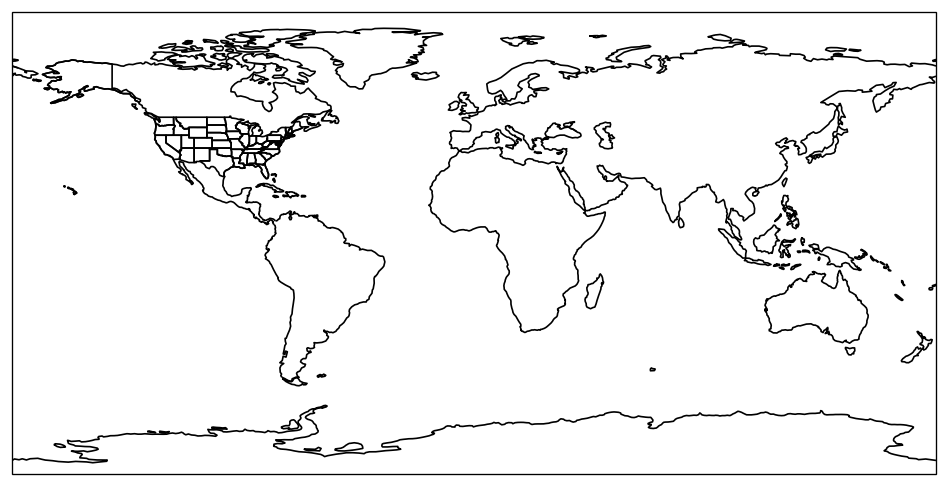

In [15]:
fig, ax = plt.subplots(
    figsize=(10,5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.coastlines()
ax.add_feature(cfeature.STATES)

US_anom = anom.plot(
    ax = ax,
    transform = ccrs.PlateCarree(),
    cmap='RdBu'
)

fig.savefig("US_anoms.png")
plt.close(fig)